# Generative Adversarial Network for enhancing Hi-C data resolution

### Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import sys

### Loading data

In [2]:
data = np.load("deephic.npz")
print(data.files)

['data', 'target', 'inds', 'compacts', 'sizes']


In [3]:
#We take only first 10,000 samples 

trainData = data["data"][:10000]
targetData = data["target"][:10000]
indsData = data["inds"][:10000]

validDataSet = np.load("deephicValid.npz")

In [4]:
validTrainData = validDataSet['data'][:10000]
validTargetData = validDataSet['target'][:10000]
validIndsData = validDataSet['inds'][:10000]

In [5]:
sqTrainData = tf.expand_dims(tf.squeeze(trainData), -1)
sqTargetData = tf.expand_dims(tf.squeeze(targetData), -1)

In [6]:
sqValidTrainData = tf.expand_dims(tf.squeeze(validTrainData), -1)
sqValidTargetData = tf.expand_dims(tf.squeeze(validTargetData), -1)

### Loading model

In [7]:
generator = tf.keras.models.load_model('generator')
discriminator = tf.keras.models.load_model('discriminator')

# Discriminator

In [5]:
def makeDiscriminator():
    inputs = tf.keras.Input(shape=(40, 40, 1))
    
    x = layers.Conv2D(filters=64, kernel_size=3, strides = 2, padding='same')(inputs)
    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    
    outputs = x
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Generator

In [6]:
def makeGenerator():
    inputs = tf.keras.Input(shape=(40, 40, 1))

    x = layers.Conv1D(filters=64, kernel_size=9, padding='same')(inputs)
    x = layers.Activation('swish')(x)
    
    x1 = layers.Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x1 = layers.BatchNormalization(momentum=0.9)(x1)
    x1 = layers.Activation('swish')(x1)
    
    x1 = layers.Conv1D(filters=64, kernel_size=3, padding='same')(x1)
    x1 = layers.BatchNormalization(momentum=0.9)(x1)
    
    x1 = layers.Add()([x1, x])
    
    x1 = layers.Conv1D(filters=64, kernel_size=3, padding='same')(x1)
    x1 = layers.Activation('swish')(x1)
    
    
    x1 = layers.Add()([x1, x])
    
    x1 = layers.Conv1D(filters=1, kernel_size=9, padding='same')(x1)
    
    outputs = x1
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

## Losses

In [35]:
def discriminatorLoss(real_output, fake_output, cross_entropy):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [36]:
def generatorLoss(fake_output, cross_entropy, real, gen):
    return cross_entropy(tf.ones_like(fake_output), fake_output)*0.01 + \
tf.math.reduce_sum(tf.keras.metrics.mean_squared_error(real, gen))

## Training step

In [1]:
#If you want to train a new model uncomment the code below:

#discriminator = makeDiscriminator()
#generator = makeGenerator()

In [28]:
#Optimizers and crossentropy initialization

crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generatorOptimizer = tf.keras.optimizers.Adam(1e-4)
discriminatorOptimizer = tf.keras.optimizers.Adam(1e-4)

In [29]:
def train_step(realHighData,realLowData):

    with tf.GradientTape() as genTape, tf.GradientTape() as discTape:
        generatedMatrices = generator(realLowData, training=True)

        realOutput = discriminator(realHighData, training=True)
        fakeOutput = discriminator(generatedMatrices, training=True)

        genLoss = generatorLoss(fakeOutput, crossEntropy, realHighData, generatedMatrices)
        discLoss = discriminatorLoss(realOutput, fakeOutput, crossEntropy)
    gradientsOfGenerator = genTape.gradient(genLoss, generator.trainable_variables)
    gradientsOfDiscriminator = discTape.gradient(discLoss, discriminator.trainable_variables)
    generatorOptimizer.apply_gradients(zip(gradientsOfGenerator, generator.trainable_variables))
    discriminatorOptimizer.apply_gradients(zip(gradientsOfDiscriminator, discriminator.trainable_variables))
    return genLoss, discLoss

## Dataset preparation

In [30]:
BatchSize = 500

indices = tf.range(start=0, limit=tf.shape(sqTrainData)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

trainData1 = tf.gather(sqTrainData, shuffled_indices)
targetData1 = tf.gather(sqTargetData, shuffled_indices)

trainDataset = tf.data.Dataset.from_tensor_slices(trainData1).batch(BatchSize)
targetDataset = tf.data.Dataset.from_tensor_slices(targetData1).batch(BatchSize)

## Training the model

In [31]:
def train(trainDataset, targetDataset, epochs):
    for epoch in range(epochs):
        print("Epoka: ", epoch)
        i = 0
        for batchTrain, batchTarget in zip(trainDataset, targetDataset):
            genLoss, discLoss = train_step(batchTarget, batchTrain)
            tf.print("Nr batcha: ", i, " Generator Loss: ", genLoss, " Discriminator Loss: ", discLoss)
            i += 1
    
    return generator

In [37]:
train(trainDataset, targetDataset, 100)

Epoka:  0
Nr batcha:  0  Generator Loss:  750.072144  Discriminator Loss:  0.651417732
Nr batcha:  1  Generator Loss:  4713.12305  Discriminator Loss:  1.33803856
Nr batcha:  2  Generator Loss:  1398.8866  Discriminator Loss:  0.94749105
Nr batcha:  3  Generator Loss:  1702.17859  Discriminator Loss:  0.836700439
Nr batcha:  4  Generator Loss:  2693.15137  Discriminator Loss:  0.847797751
Nr batcha:  5  Generator Loss:  2605.2688  Discriminator Loss:  0.691636801
Nr batcha:  6  Generator Loss:  1265.97913  Discriminator Loss:  0.632760882
Nr batcha:  7  Generator Loss:  838.309  Discriminator Loss:  0.572001
Nr batcha:  8  Generator Loss:  1706.1416  Discriminator Loss:  0.530188918
Nr batcha:  9  Generator Loss:  1934.90503  Discriminator Loss:  0.588752925
Nr batcha:  10  Generator Loss:  1733.02246  Discriminator Loss:  0.64128077
Nr batcha:  11  Generator Loss:  1614.26428  Discriminator Loss:  0.631475449
Nr batcha:  12  Generator Loss:  826.495117  Discriminator Loss:  0.95218652

KeyboardInterrupt: 

### Saving the model

In [77]:
discriminator.save('discriminator')
generator.save('generator')

INFO:tensorflow:Assets written to: discriminator\assets


INFO:tensorflow:Assets written to: discriminator\assets


# Results

In [10]:
#The function returns full Hi-C matrix given its fragments

def makeHic(indsData, data, xShape, yShape, hicNum):
    datat = tf.squeeze(data)
    S = np.zeros((xShape, yShape), dtype=float)
    i = 0
    for x,y in zip(indsData[indsData[:,0]==hicNum,:][:,2], indsData[indsData[:,0]==hicNum,:][:,3]):
        S[x:x+40, y:y+40] += datat[i]
        i+=1
    
    return S

### Training data

In [8]:
generatedData1 = tf.expand_dims(tf.squeeze(generator(sqTrainData[:3021])), 1).numpy()
generatedData2 = tf.expand_dims(tf.squeeze(generator(sqTrainData[3021:6042])), 1).numpy()

generatedData = np.concatenate((generatedData1, generatedData2), 0)

In [11]:
trainHic = makeHic(indsData, trainData, 22080, 22080, 1)
targetHic = makeHic(indsData, targetData, 22080, 22080, 1)

In [12]:
ourHic = makeHic(indsData, generatedData, 22080, 22080, 1)

#### Generated by our model

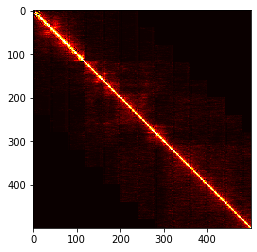

In [13]:
plt.imshow(ourHic[:500, :500], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.show()

#### Target

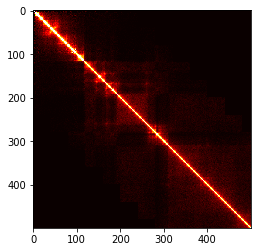

In [14]:
plt.imshow(targetHic[:500, :500], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.show()

#### Low quality

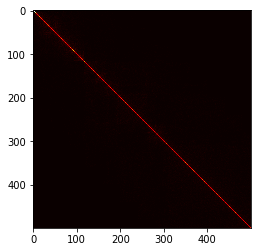

In [15]:
plt.imshow(trainHic[:500, :500], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.show()

### Test data

In [8]:
generatedData1 = tf.expand_dims(tf.squeeze(generator(sqValidTrainData[:3021])), 1).numpy()
generatedData2 = tf.expand_dims(tf.squeeze(generator(sqValidTrainData[3021:6042])), 1).numpy()

generatedData = np.concatenate((generatedData1, generatedData2), 0)

In [15]:
trainHic = makeHic(validIndsData, validTrainData, 22080, 22080, 8)
targetHic = makeHic(validIndsData, validTargetData, 22080, 22080, 8)

In [17]:
ourHic = makeHic(validIndsData, generatedData, 22080, 22080, 8)

#### Generated by our model

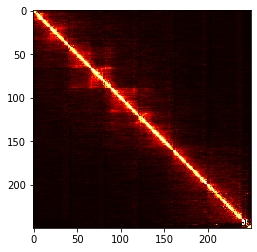

In [41]:
plt.imshow(ourHic[4000:4250,4000:4250], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.show()

#### Target

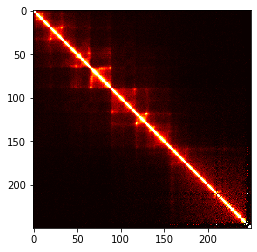

In [42]:
plt.imshow(targetHic[4000:4250,4000:4250], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.show()

#### Low quality

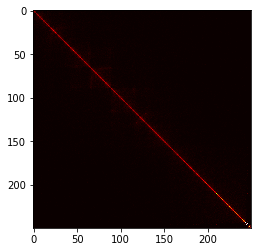

In [43]:
plt.imshow(trainHic[4000:4250,4000:4250], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.show()